In [1]:
import pandas as pd
import random
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [26]:
# Download the dataset once
if not os.path.exists('fakenet_dataset'):
    !aws s3 cp s3://danylo-ucla/fakenet_dataset.zip ./
    !unzip fakenet_dataset.zip >/dev/null

download: s3://danylo-ucla/fakenet_dataset.zip to ./fakenet_dataset.zip


In [2]:
!tree -L 2 fakenet_dataset

fakenet_dataset
├── score
│   ├── images
│   └── metadata.csv
└── train
    ├── images
    └── metadata.csv

4 directories, 2 files


## Training Images and Metadata

In [3]:
train_metadata = pd.read_csv('fakenet_dataset/train/metadata.csv')

In [4]:
train_metadata.head()

,file_name_training,file_name_generated,caption
0,ffd603965b2eb89bfa6e7bda19c903f9.jpg,d70026e562baeb2976d33ea72bbe2af2.jpg,a toilet with a green and white door and green...
1,c5e15bda1013a6a8c28b87d23aa94767.jpg,41c055de712d74957659ab5d901c4212.jpg,An older couple embracing each other next to a...
2,517547ba7695808a52ecd2e2f4b6faf7.jpg,aab1106eb9793b08b665902c74c8e0cf.jpg,"A square glazed doughnut, and a chocolate doug..."
3,c3ff13909de96ed069fb2769800ea4b9.jpg,0658524e5dc4058fe7ceff0a72dbda18.jpg,A large bathroom with tiled floor and big mirror
4,2b5c6c916a7110287f7193081906cc5e.jpg,8546adea5c43ea5e517abfa5208aa10d.jpg,A man riding a snowboard down a conveyor belt.


In [5]:
random.seed(43)

([], [])

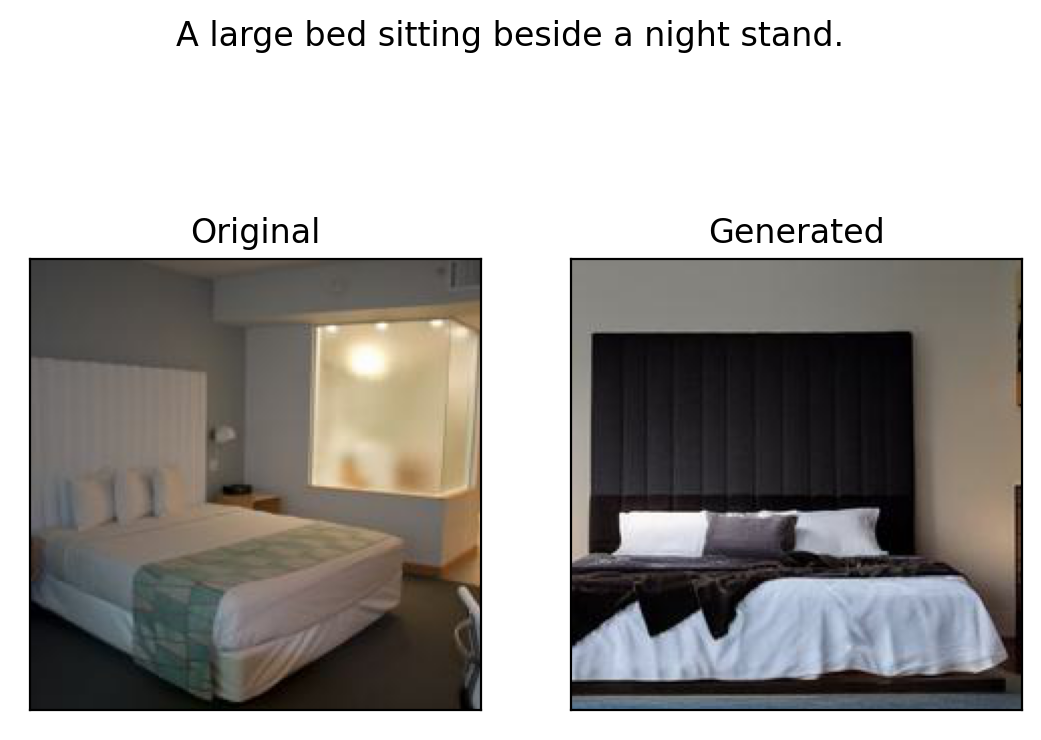

In [6]:
i = random.randint(0, train_metadata.shape[0])

file_name_training = train_metadata['file_name_training'].iloc[i]
file_name_generated = train_metadata['file_name_generated'].iloc[i]
caption = train_metadata['caption'].iloc[i]

plt.suptitle(caption)

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_training}'))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.title('Generated')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_generated}'))
plt.xticks([])
plt.yticks([])

## Score Images and Metadata

In [7]:
score_metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
score_metadata

,file_name_a,file_name_b,caption
0,7ad84509c9b0226bc0288537a8ab22ae.jpg,798d20e113a6bde4525336ce66a84a69.jpg,A couple of motorcycles parked next to each ot...
1,a4a39968e428b3c82257e25920e3adeb.jpg,2d6c056b045062c97450a29dd83d8c63.jpg,A vase with a bird on it and a matching winegl...
2,38ffec577b2c097f3a3403ae6c6638b8.jpg,050d2c637cbfa509f9a0072d6ca422b5.jpg,a man that is surfing on some water
3,07ecbbbc269ba1bd2d5b792f9abea0ed.jpg,23cbc59d33f061d2930f27c641a01807.jpg,A crowd of young people sanding on a snow cove...
4,10c585ad69ed895ac1a3b58d5dfb256a.jpg,7bbe5ae59f098437099f5ba093c2b38b.jpg,"A kitchen with a refrigerator, counter and was..."
...,...,...,...
2811,1541d399a4be2e0c85ef061e6bddb60c.jpg,15e819f3f3ede6e2e20170d71185031d.jpg,a close up of a person wearing a suit and tie
2812,d1bc62f2b725409f46421219f16383df.jpg,06f2ad1c20ed610523d677e3cbb8fed6.jpg,Zebras eat from a trough set up in their zoo e...
2813,7015aa30ddb1d1605c6822d2856e98db.jpg,846bd374ab91c40386fa48c1f5fdef78.jpg,A group of people on a field with a Frisbee.
2814,3b76a717ad707699851465a0680f5798.jpg,f5a5c27c396aae7142805befc710f9ac.jpg,A boy sitting at a table eating food with food...


## Creating Tensorflow Dataset (Single Image, Labeled Segment)

In [8]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled_single(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            training_path = 'fakenet_dataset/train/images/' + row['file_name_training']
            generated_path = 'fakenet_dataset/train/images/' + row['file_name_generated']

            training_np = np.array(Image.open(training_path)).astype(np.float32)
            generated_np = np.array(Image.open(generated_path)).astype(np.float32)

            model_input = training_np
            model_output = (1,)
            yield (model_input, model_output)

            model_input = generated_np
            model_output = (0,)
            yield (model_input, model_output)
    return generator


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled_single(metadata: pd.DataFrame) -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore
    model_output = tf.TensorSpec(shape=(1,), dtype=tf.int32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled_single(metadata), 
        output_signature=dataset_signature
    )

    return dataset


In [9]:
train_single_dataset = build_dataset_labeled_single(train_metadata)
model_input, model_output = next(iter(train_single_dataset))
display(model_input.shape, model_output.shape)

2022-10-17 00:38:34.386752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 00:38:34.412865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 00:38:34.413038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 00:38:34.413940: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

TensorShape([224, 224, 3])

TensorShape([1])

In [10]:
train_single_dataset = train_single_dataset.batch(16)
model_input, model_output = next(iter(train_single_dataset))
display(model_input.shape, model_output.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

## Creating Tensorflow Dataset (Single Image, Score Segment)

In [11]:
import tensorflow as tf
import numpy as np

# See Python Generator
# https://peps.python.org/pep-0255/
def generator_score_single():
    metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
    
    for _, row in metadata.iterrows():
        image_a_path = 'fakenet_dataset/score/images/' + row['file_name_a']
        image_b_path = 'fakenet_dataset/score/images/' + row['file_name_b']

        image_a_np = np.array(Image.open(image_a_path))
        image_b_np = np.array(Image.open(image_b_path))

        model_input = image_a_np
        yield model_input

        # Uncomment if you want to compare the two images after inference
        # model_input = image_b_np
        # yield model_input


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_score_single() -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    dataset_signature = model_input

    dataset = tf.data.Dataset.from_generator(
        generator_score_single, 
        output_signature=dataset_signature
    )

    return dataset

In [12]:
score_single_dataset = build_dataset_score_single().batch(16)
model_input = next(iter(score_single_dataset))
display(model_input.shape)

TensorShape([16, 224, 224, 3])

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile('sgd', 'binary_crossentropy')
model.fit(train_single_dataset)
score_y_hat = model.predict(score_single_dataset)

1408/1408 [==============================] - 29s 20ms/step - loss: 2081598.0000


## Creating Tensorflow Dataset (Paired Images, Labeled Segment)

In [14]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled_paired(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            training_path = 'fakenet_dataset/train/images/' + row['file_name_training']
            generated_path = 'fakenet_dataset/train/images/' + row['file_name_generated']

            training_np = np.array(Image.open(training_path))
            generated_np = np.array(Image.open(generated_path))

            model_output = np.random.randint(low=0, high=2, size=1)

            if model_output == 0:
                model_input = (training_np, generated_np)
            else:
                model_input = (generated_np, training_np)

            yield (model_input, model_output)

    return generator

# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled_paired(metadata: pd.DataFrame):
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    model_input = (image_signature, image_signature)
    model_output = tf.TensorSpec(shape=(1,), dtype=tf.int32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled_paired(metadata), 
        output_signature=dataset_signature
    )

    return dataset

In [15]:
train_paired_dataset = build_dataset_labeled_paired(train_metadata).batch(16)

(model_input_a, model_input_b), model_output = next(iter(train_paired_dataset))

display(model_input_a.shape, model_input_b.shape, model_output.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [16]:
# See Python Generator
# https://peps.python.org/pep-0255/
def generator_score_paired():
    metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')

    for _, row in metadata.iterrows():
        image_a_path = 'fakenet_dataset/score/images/' + row['file_name_a']
        image_b_path = 'fakenet_dataset/score/images/' + row['file_name_b']

        image_a_np = np.array(Image.open(image_a_path))
        image_b_np = np.array(Image.open(image_b_path))

        model_input = (image_a_np, image_b_np)
        yield (model_input,)


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_score_paired():
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    model_input = (image_signature, image_signature)

    dataset_signature = (model_input,)

    dataset = tf.data.Dataset.from_generator(
        generator_score_paired, 
        output_signature=dataset_signature
    )

    return dataset

In [17]:
score_paired_dataset = build_dataset_score_paired().batch(16)

((model_input_a, model_input_b),) = next(iter(score_paired_dataset))

display(model_input_a.shape, model_input_b.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

In [18]:
# See Keras Functional API
# https://keras.io/guides/functional_api/

inputs = [
    tf.keras.layers.Input((224, 224, 3)),
    tf.keras.layers.Input((224, 224, 3)),
]

# Example of reusing the same layer twice.
# A Model object (e.g. a pre-trained model) can also be used multiple times.
dense = tf.keras.layers.Dense(1)
outputs = [
    dense(inputs[0]),
    dense(inputs[1]),
]

outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile('sgd', 'binary_crossentropy')
model.fit(train_paired_dataset)
score_y_hat = model.predict(score_paired_dataset)


704/704 [==============================] - 26s 37ms/step - loss: 1.2633


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense_1 (Dense)                (None, 224, 224, 1)  4           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [20]:
# The expected model output for the score segment is a DataFrame with 1 column -- 'probability'.
# One probability per row in the score metadata.
# The probability represents the likelihood that the image in the 'file_name_a' column is real.

# The following code can be used to check the DataFrame in 'score_y_hat':

score_y_hat = pd.DataFrame(score_y_hat, columns=['probability'])
assert score_y_hat.shape == (score_metadata.shape[0], 1)
assert score_y_hat.probability.dtype == np.float32
assert score_y_hat.probability.min() >= 0
assert score_y_hat.probability.max() <= 1

In [21]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. the probabilities for the score segment

import os
model_dir = 'fakenet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')